### Install and Import Libraries

In [5]:
# !pip install nibabel
# !pip install opencv-python

In [6]:
import os
import numpy as np
from matplotlib import pyplot as plt
from skimage import metrics
import nibabel as nib
import pandas as pd
from scipy.signal import lfilter

### Data Loading

In [7]:
def slice_show(image, slice_no):
    """ 
    A function to visualize 2D slices from 3D volume Image.
    Inputs 
      image: 3D Nifti Image
      slice_no: Which Slice you want to visualize
    Outputs
      plot the images
    
    """
    plt.figure()
    plt.axis('off')
    plt.imshow(image[:,:,slice_no].T, cmap='gray')

In [8]:
#Creating folders for each of the training images where the results will be stored

# base_directory= 'F:\\udG\\MIRA\\Labs\\Lab03Atlas\\outputs\\'
# data_list = ['1000', '1001', '1002', '1006', '1007', '1008',
#             '1009', '1010', '1011', '1012', '1013', '1014',
#             '1015', '1017', '1036'] 
# for i in data_list:
#     path= os.path.join(base_directory,i)
#     os.mkdir(path)

In [9]:
#Creating subfolders in each of the previously created folders for the moving images in each iteration

# data_list = ['1000', '1001', '1002', '1006', '1007', '1008',
#             '1009', '1010', '1011', '1012', '1013', '1014',
#             '1015', '1017', '1036'] 
# for dirs in os.listdir(base_directory):
#     data_list_new= [n for n in data_list if n!= dirs]
#     current_path= os.path.join(base_directory,dirs)
#     for i in data_list_new:
#         path = os.path.join(current_path,i)
#         os.mkdir(path)


In [10]:
# Id's of the given images
data_list = ['1000', '1001', '1002', '1006', '1007', '1008',
            '1009', '1010', '1011', '1012', '1013', '1014',
            '1015', '1017', '1036'] 

# A list for holding normalized root mean square errors per fixed image
rmse_list = [] 

#Important directories for OS Operation
elastix_directory = 'F:\\udG\\MIRA\\Labs\\Lab03Atlas\\elastix'
input_directory = 'F:\\udG\\MIRA\\Labs\\Lab03Atlas\\training-images\\'
output_directory = 'F:\\udG\\MIRA\\Labs\\Lab03Atlas\\outputs\\'
parameter_affine_directory = 'F:\\udG\\MIRA\\Labs\\Lab03Atlas\\Par009Affine.txt'
parameter_elastic_directory = 'F:\\udG\\MIRA\\Labs\\Lab03Atlas\\Par009Elastic.txt'

###### To be able to run this code you have to rearrange your output folder like this way

<div>
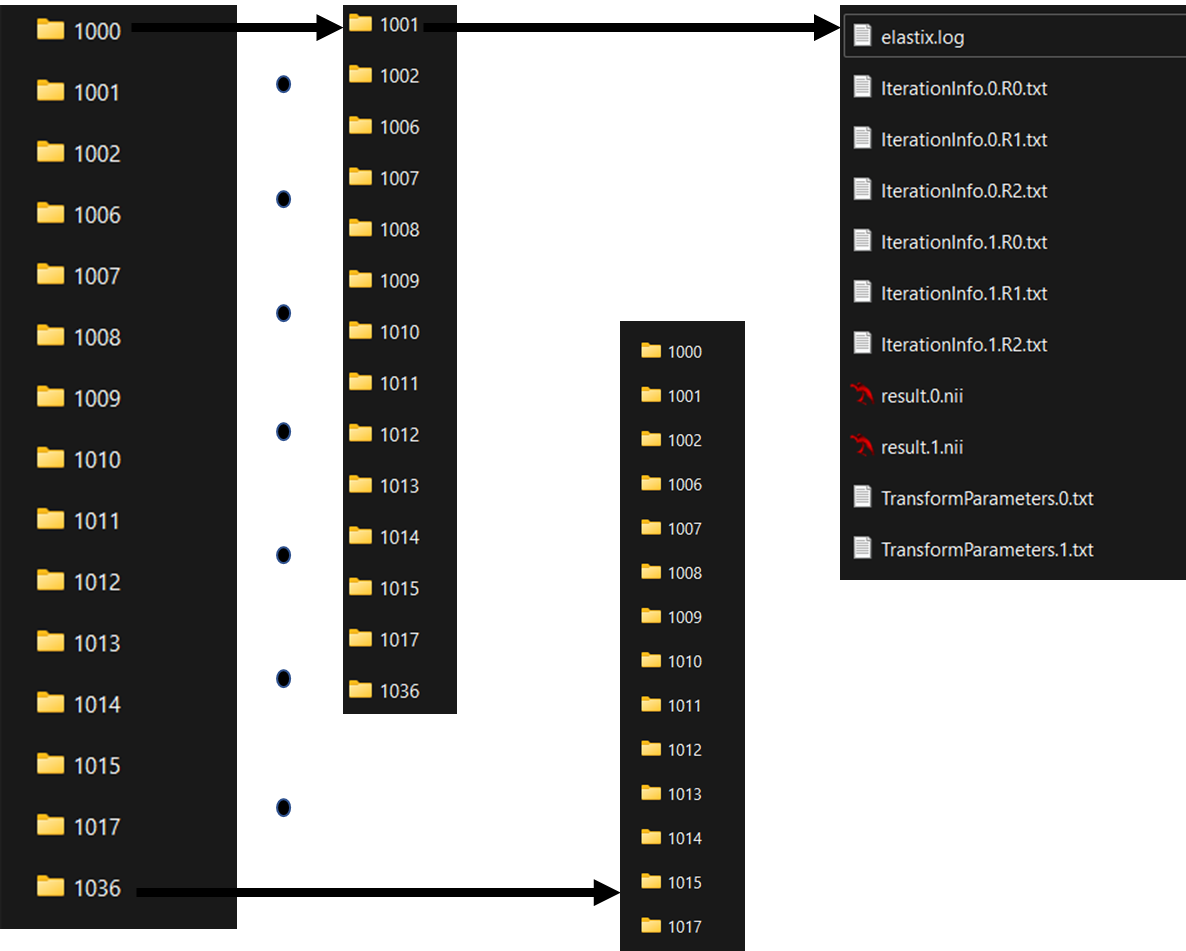
</div>

### Image Registration

In [11]:
# Block for generating Image Registration for each fixed image
#Getting the names for each image
for fixed in data_list:

    #temporary output directory for fixed image 
    temp_output_directory = output_directory + fixed + '\\'
    # Location for the fixed image
    #current directory of the fixed image 1000.nii 
    current_fixed_directory = input_directory + fixed + '.nii'
    #loading fixed image
    fixed_img_data = nib.load(current_fixed_directory)
    # fixed image data
    current_fixed_img = fixed_img_data.get_fdata()
    # Initialization of normalized root mean squared error for each iteration in the loop
    rmse_sum = 0 
    for moving in data_list:
        #making sure moving image is different to the fixed. 
        if(moving != fixed):
            # Location to the place where output results will be stored
            current_output_directory = temp_output_directory + moving + '\\'
            # Location for the moving image
            current_moving_directory = input_directory + moving + '.nii'
            
            # Generating Image Registration for all the fixed images (Run Once)
            os.system("cd /d F: && cd "+elastix_directory+"&& elastix -f "+current_fixed_directory+" -m "+current_moving_directory+" -out "+current_output_directory+" -p "+parameter_affine_directory+" -p "+parameter_elastic_directory+"")
            
            # Location of the final registered image after affine and elastic trasformation 
            current_result_directory = current_output_directory + 'result.1.nii'
            
            # Final Registered image
            result_img_data = nib.load(current_result_directory)
            current_result_img = result_img_data.get_fdata()
            
            # Computing and storing the error metric
            current_error = metrics.normalized_root_mse(current_fixed_img, current_result_img)
            rmse_sum = rmse_sum + current_error
    #Computing average RMSE
    rmse_avg = rmse_sum/14
    rmse_list.append((fixed,rmse_avg))

In [12]:
# Finding the fixed image with lowest rmse
df = pd.DataFrame (rmse_list, columns = ['fixed_image', 'RMSE'])
print (df)


   fixed_image      RMSE
0         1000  0.350595
1         1001  0.461044
2         1002  0.499629
3         1006  0.346033
4         1007  0.384170
5         1008  0.329731
6         1009  0.377230
7         1010  0.380148
8         1011  0.355938
9         1012  0.488612
10        1013  0.354709
11        1014  0.460180
12        1015  0.430695
13        1017  0.439301
14        1036  0.627759


### Label Propagation

In [13]:
# Label transformation for Probabilistic Atlas
best_fixed_img_num = '1008'

# Locations for the ground truths
labels_directory = 'F:\\udG\\MIRA\\Labs\\Lab03Atlas\\training-labels\\'
temp_labels_output_directory = 'F:\\udG\\MIRA\\Labs\\Lab03Atlas\\outputs\\'

# location of the place where the transformed label will be stored
labels_output_directory = temp_labels_output_directory + best_fixed_img_num + '\\'

for data in data_list:
    if data != best_fixed_img_num:
        current_labels_directory = labels_directory + data + '_3C.nii'
        current_labels_output_directory = labels_output_directory + data + '\\'
        # The final transformation matrix generated after Image Registration
        transformix_param_directory = current_labels_output_directory + 'TransformParameters.1.txt'
        # Transform the labels too using the matrix generated after image registration (Run Once)
        # os.system("cd /d F: && cd "+elastix_directory+"&& transformix -in "+current_labels_directory+" -out "+current_labels_output_directory+" -tp "+transformix_param_directory+"")
        

### Intensity Atlas

In [14]:
# Label transformation for Probabilistic Atlas
best_fixed_img_num = '1008'

# Extracting the best fixed image with lowest rmse
best_fixed_img_directory = 'F:\\udG\\MIRA\\Labs\\Lab03Atlas\\training-images\\'+best_fixed_img_num+'.nii'
best_fixed_img_data = nib.load(best_fixed_img_directory)
best_fixed_img = best_fixed_img_data.get_fdata()

# Initializing Intensity Atlas image with the same shape of the fixed image
intensity_atlas_img = np.zeros((best_fixed_img.shape))
# Location to store the results
intensity_output_directory = labels_output_directory
for data in data_list:
    if data != best_fixed_img_num:
        # Traversing each output image registration result and adding up to the intensity atlas
        current_intensity_output_directory = intensity_output_directory + data + '\\result.1.nii'
        current_intensity_atlas_data = nib.load(current_intensity_output_directory)
        current_intensity_atlas_img = current_intensity_atlas_data.get_fdata()
        intensity_atlas_img = intensity_atlas_img + current_intensity_atlas_img
    #In case the image corresponds to the fixed image, the original image is used for generating the intensity atlas
    else: 
        current_intensity_output_directory = input_directory + data + '.nii'
        current_intensity_atlas_data = nib.load(current_intensity_output_directory)
        current_intensity_atlas_img = current_intensity_atlas_data.get_fdata()
        intensity_atlas_img = intensity_atlas_img + current_intensity_atlas_img
# getting the average intensity dividing by the total number of images
intensity_atlas_img = intensity_atlas_img/15

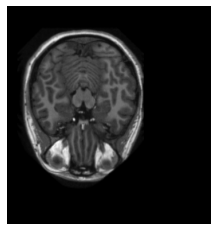

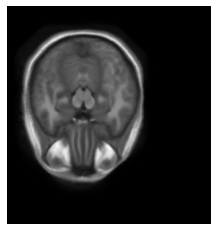

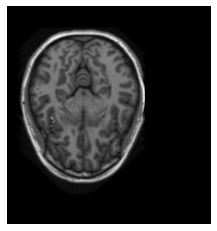

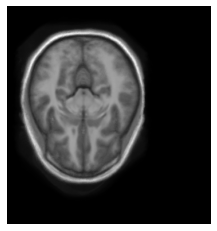

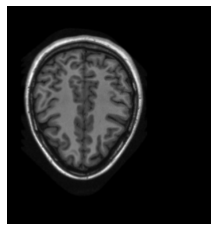

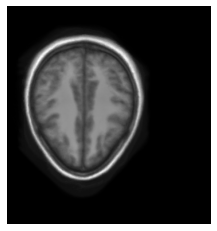

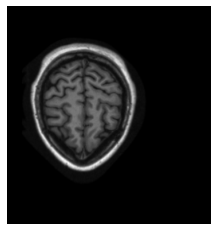

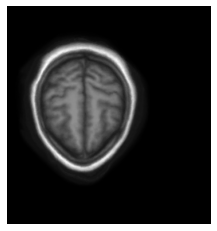

In [40]:
# Visualize the intensity atlas result per one slice CORRECTED (15)
slice_1 = 90
slice_2 = 100
slice_3 = 144
slice_4= 160

slice_show(best_fixed_img, slice_1)
slice_show(intensity_atlas_img, slice_1)

slice_show(best_fixed_img, slice_2)
slice_show(intensity_atlas_img, slice_2)

slice_show(best_fixed_img, slice_3)
slice_show(intensity_atlas_img, slice_3)

slice_show(best_fixed_img, slice_4)
slice_show(intensity_atlas_img, slice_4)



In [16]:
# Saving the results for intensity atlas
intensity_atlas_nifti = nib.Nifti1Image(intensity_atlas_img, best_fixed_img_data.affine, best_fixed_img_data.header)
nib.save(intensity_atlas_nifti, output_directory + '/intensity_atlas_nifti.nii')

### Probabilistic Atlas

In [17]:
# Probabilistic Atlas

# Initialization of three probabilistic atlas image with the same shape of the fixed image
sum_csf = np.zeros((best_fixed_img.shape))
sum_wm = np.zeros((best_fixed_img.shape))
sum_gm = np.zeros((best_fixed_img.shape))
for data in data_list:
    if data != best_fixed_img_num:
        # Traversing along the transformed labels for each case of the moving images
        current_label_output_directory = intensity_output_directory + data + '\\result.nii'
        current_label_data = nib.load(current_label_output_directory)
        # Getting the labeled image generated after label propagation step
        current_label = current_label_data.get_fdata()
        # Making copies of the label image
        mask_csf = current_label.copy()
        mask_wm = current_label.copy()
        mask_gm = current_label.copy()
        # Generating masks for each of the class ( CSF:1, WM:2, GM:3 )
        mask_csf[mask_csf != 1] = 0
        mask_wm[mask_wm != 2] = 0
        mask_gm[mask_gm != 3] = 0
        mask_wm[mask_wm==2]=1
        mask_gm[mask_gm==3]=1
        # Adding up for all moving image labels
        sum_csf = sum_csf + mask_csf
        sum_wm = sum_wm + mask_wm
        sum_gm = sum_gm + mask_gm

    #In case the image is equal to the fixed one, the original label is used
    
    else:
        current_label_output_directory= labels_directory + data + '_3C.nii'
        current_label_data = nib.load(current_label_output_directory)
        current_label = current_label_data.get_fdata()

        # Making copies of the label image
        mask_csf = current_label.copy()
        mask_wm = current_label.copy()
        mask_gm = current_label.copy()
        # Generating masks for each of the class ( CSF:1, GM:2, WM:3 )
        mask_csf[mask_csf != 1] = 0
        mask_wm[mask_wm != 2] = 0
        mask_gm[mask_gm != 3] = 0
        mask_wm[mask_wm==2]=1
        mask_gm[mask_gm==3]=1
        # Adding up for all moving image labels
        sum_csf = sum_csf + mask_csf
        sum_wm = sum_wm + mask_wm
        sum_gm = sum_gm + mask_gm
        
# Getting the average dividng by total number of images 
probabilistic_atlas_csf = sum_csf / 15
probabilistic_atlas_wm = sum_wm / 15
probabilistic_atlas_gm =  sum_gm /15

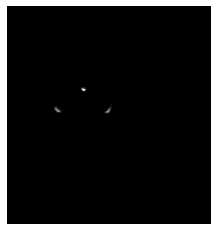

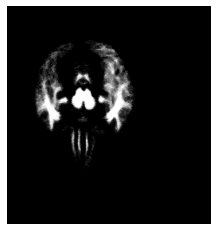

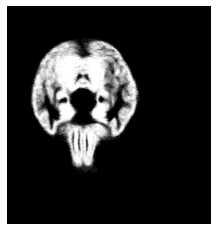

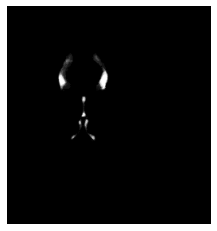

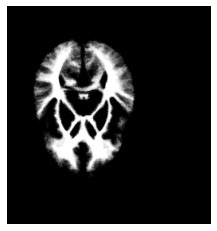

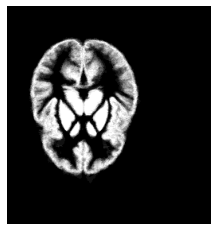

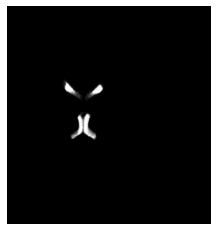

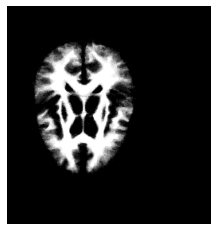

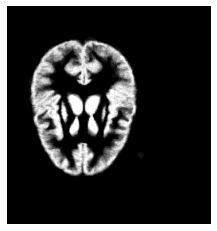

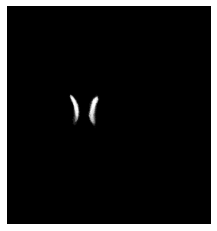

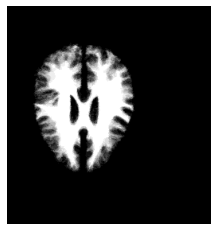

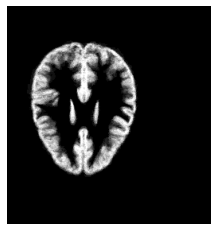

In [38]:
# Visualize the probabilistic atlas result per one slice per each class, 15 images corrected
slice_1 = 90
slice_2 = 110
slice_3 = 120
slice_4= 130

slice_show(probabilistic_atlas_csf, slice_1)
slice_show(probabilistic_atlas_wm, slice_1)
slice_show(probabilistic_atlas_gm, slice_1)

slice_show(probabilistic_atlas_csf, slice_2)
slice_show(probabilistic_atlas_wm, slice_2)
slice_show(probabilistic_atlas_gm, slice_2)

slice_show(probabilistic_atlas_csf, slice_3)
slice_show(probabilistic_atlas_wm, slice_3)
slice_show(probabilistic_atlas_gm, slice_3)

slice_show(probabilistic_atlas_csf, slice_4)
slice_show(probabilistic_atlas_wm, slice_4)
slice_show(probabilistic_atlas_gm, slice_4)


In [94]:
# Saving the results for probabilistic atlas
probabilistic_atlas_csf_nifti = nib.Nifti1Image(probabilistic_atlas_csf, best_fixed_img_data.affine, best_fixed_img_data.header)
nib.save(probabilistic_atlas_csf_nifti, output_directory + '/probabilistic_atlas_csf.nii')
probabilistic_atlas_wm_nifti = nib.Nifti1Image(probabilistic_atlas_wm, best_fixed_img_data.affine, best_fixed_img_data.header)
nib.save(probabilistic_atlas_wm_nifti, output_directory + '/probabilistic_atlas_wm.nii')
probabilistic_atlas_gm_nifti = nib.Nifti1Image(probabilistic_atlas_gm, best_fixed_img_data.affine, best_fixed_img_data.header)
nib.save(probabilistic_atlas_gm_nifti, output_directory + '/probabilistic_atlas_gm.nii')

### Histograms

In [41]:
#Generating a vector that contains the intensity pixels that belong to each of the tissues
for data in data_list:
    c= 1
    #If the iteration is the first, the vector is initialized
    if data != best_fixed_img_num and c==1:
        #Obtaining registered image and registered label for moving image
        current_registered_image_directory =  intensity_output_directory + data + '\\result.1.nii'
        current_label_output_directory = intensity_output_directory + data + '\\result.nii'
        #Loading registered image and registered label
        current_registered_image_data= nib.load(current_registered_image_directory)
        current_label_data = nib.load(current_label_output_directory)
        current_registered_image= current_registered_image_data.get_fdata()
        current_label = current_label_data.get_fdata()
        #Making copies of the label image
        mask_csf = current_label.copy()
        mask_gm = current_label.copy()
        mask_wm = current_label.copy()
        #Getting the intensity pixels that belong to each class 
        intensities_csf= current_registered_image[mask_csf==1]
        intensities_wm= current_registered_image[mask_wm==2]
        intensities_gm= current_registered_image[mask_gm==3]
        
    elif data != best_fixed_img_num:
        #Obtaining registered image and registered label for moving images 
        current_registered_image_directory =  intensity_output_directory + data + '\\result.1.nii'
        current_label_output_directory = intensity_output_directory + data + '\\result.nii'
        #Loading registered image and registered label
        current_registered_image_data= nib.load(current_registered_image_directory)
        current_label_data = nib.load(current_label_output_directory)
        current_registered_image= current_registered_image_data.get_fdata()
        current_label = current_label_data.get_fdata()
        # Getting the labeled image generated after label propagation step
        # Making copies of the label image
        mask_csf = current_label.copy()
        mask_gm = current_label.copy()
        mask_wm = current_label.copy()
        #Getting the intensity pixels that belong to each class and saving them in a vector
        intensities_csf= np.concatenate([intensities_csf, current_registered_image[mask_csf==1]])
        intensities_wm= np.concatenate([intensities_wm, current_registered_image[mask_wm==2]])
        intensities_gm= np.concatenate([intensities_gm, current_registered_image[mask_gm==3]])

    #In case it is the fixed image
    else:  
        # Obtaining original image and label for the fixed image 
        current_registered_image_directory =  input_directory+data+'.nii'
        current_label_output_directory = labels_directory + data + '_3C.nii'
        #Loading image and label for the fixed image
        current_registered_image_data= nib.load(current_registered_image_directory)
        current_label_data = nib.load(current_label_output_directory)
        current_registered_image= current_registered_image_data.get_fdata()
        current_label = current_label_data.get_fdata()
        # Making copies of the label image
        mask_csf = current_label.copy()
        mask_gm = current_label.copy()
        mask_wm = current_label.copy()
        #Getting the intensity pixels that belong to each class and saving them in a vector
        intensities_csf= np.concatenate([intensities_csf, current_registered_image[mask_csf==1]])
        intensities_wm= np.concatenate([intensities_wm, current_registered_image[mask_wm==2]])
        intensities_gm= np.concatenate([intensities_gm, current_registered_image[mask_gm==3]])

    c+=1


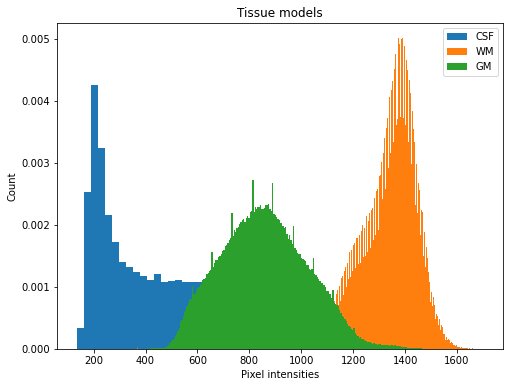

In [42]:
#Generating histogram of counts of pixels belonging to each tissue 
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.hist(intensities_csf,bins="auto",label="CSF",density=True)
plt.hist(intensities_wm, bins="auto", label= "WM", density=True)
plt.hist(intensities_gm, bins="auto", label= "GM", density=True)
plt.title('Tissue models')
plt.xlabel('Pixel intensities')
plt.ylabel('Count')
plt.legend(loc='upper right')

<ipython-input-43-13e9c0374b6f>:9: RuntimeWarning: invalid value encountered in true_divide
  normalized_histogram_csf= np.divide(histogram_csf,sum_histogram)
<ipython-input-43-13e9c0374b6f>:10: RuntimeWarning: invalid value encountered in true_divide
  normalized_histogram_wm= np.divide(histogram_wm, sum_histogram)
<ipython-input-43-13e9c0374b6f>:11: RuntimeWarning: invalid value encountered in true_divide
  normalized_histogram_gm= np.divide(histogram_gm, sum_histogram)


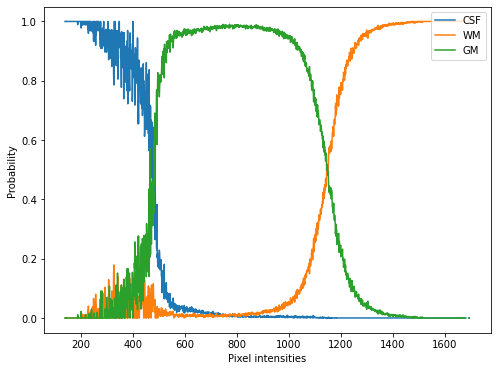

In [43]:
#Finding maximum intensity value accross all tissues
maximum_value= int(np.max([np.max(intensities_csf), np.max(intensities_wm), np.max(intensities_gm)]))
#Generating histograms for each tissue and the total histogram (sum of all tissue histograms)
histogram_csf, _= np.histogram(np.uint16(intensities_csf),range=(0,maximum_value), bins=maximum_value)
histogram_wm, _= np.histogram(np.uint16(intensities_wm),range=(0,maximum_value),bins=maximum_value)
histogram_gm, _= np.histogram(np.uint16(intensities_gm),range=(0,maximum_value),bins=maximum_value)
sum_histogram= histogram_csf+histogram_wm+histogram_gm

#Normalization of tissue histograms
normalized_histogram_csf= np.divide(histogram_csf,sum_histogram)
normalized_histogram_wm= np.divide(histogram_wm, sum_histogram)
normalized_histogram_gm= np.divide(histogram_gm, sum_histogram)

#Plot of the normalized histograms
plt.figure(figsize=(8,6))
plt.plot(range(0,maximum_value),normalized_histogram_csf,label='CSF')
plt.plot(range(0,maximum_value),normalized_histogram_wm,label='WM')
plt.plot(range(0,maximum_value),normalized_histogram_gm,label='GM')
plt.xlabel('Pixel intensities')
plt.ylabel('Probability')
plt.legend(loc='upper right')

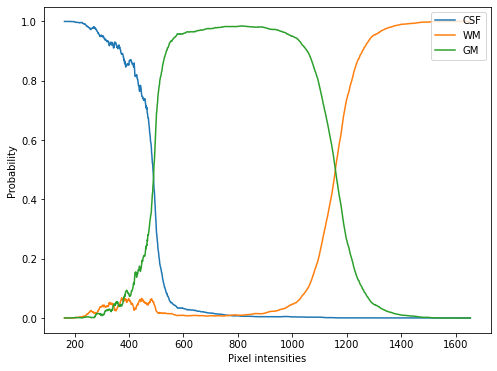

In [44]:
#Smoothing of the histograms to have a clearer figure using an IIR filter
#Parameter of the filter. The larger n, the bigger the smoothing
n=20
b=[1.0/n]*n
a=1
#Smoothing of the histograms
smoothed_histogram_csf= lfilter(b,a,normalized_histogram_csf)
smoothed_histogram_wm= lfilter(b,a,normalized_histogram_wm)
smoothed_histogram_gm= lfilter(b,a,normalized_histogram_gm)
#Plot of the histograms
plt.figure(figsize=(8,6))
plt.plot(range(0,maximum_value),smoothed_histogram_csf,label='CSF')
plt.plot(range(0,maximum_value),smoothed_histogram_wm,label='WM')
plt.plot(range(0,maximum_value),smoothed_histogram_gm,label='GM')
plt.xlabel('Pixel intensities')
plt.ylabel('Probability')
plt.legend(loc='upper right')

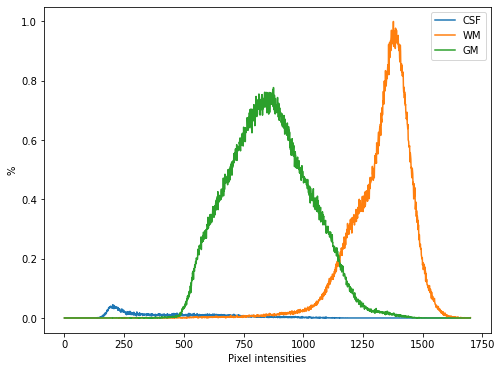

In [45]:
#Finding maximum intensity value accross all tissues
maximum_value= int(np.max([np.max(intensities_csf), np.max(intensities_wm), np.max(intensities_gm)]))
#Generating histograms for each tissue and the total histogram (sum of all tissue histograms)
histogram_csf, _= np.histogram(np.uint16(intensities_csf),range=(0,maximum_value), bins=maximum_value)
histogram_wm, _= np.histogram(np.uint16(intensities_wm),range=(0,maximum_value),bins=maximum_value)
histogram_gm, _= np.histogram(np.uint16(intensities_gm),range=(0,maximum_value),bins=maximum_value)
maximum_value_histograms= int(np.max([np.max(histogram_csf), np.max(histogram_wm), np.max(histogram_gm)]))
#Normalization of tissue histograms
normalized_histogram_csf= np.divide(histogram_csf,maximum_value_histograms)
normalized_histogram_wm= np.divide(histogram_wm, maximum_value_histograms)
normalized_histogram_gm= np.divide(histogram_gm, maximum_value_histograms)

#Plot of the normalized histograms
plt.figure(figsize=(8,6))
plt.plot(range(0,maximum_value),normalized_histogram_csf,label='CSF')
plt.plot(range(0,maximum_value),normalized_histogram_wm,label='WM')
plt.plot(range(0,maximum_value),normalized_histogram_gm,label='GM')
plt.xlabel('Pixel intensities')
plt.ylabel('%')
plt.legend(loc='upper right')